# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [ ]:
!pip install networkx==2.3

In [ ]:
!pip install StellarGraph

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [2]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clustering_Assignment/movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [3]:
edges = [tuple(x) for x in data.values.tolist()]

In [4]:
B = nx.Graph()
# Adds the first set of data(movie), here it can be in the form of unique list
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
# Adds the second set of data(actor), here it can be in the form of unique list
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
# edges should be in the form of list of tuples, refer the example in the Py docs
B.add_edges_from(edges, label='acted')

In [5]:
A = list(nx.connected_components(B))[0]

In [6]:
print("number of nodes", B.number_of_nodes())
print("number of edges", B.number_of_edges())

number of nodes 4703
number of edges 9650


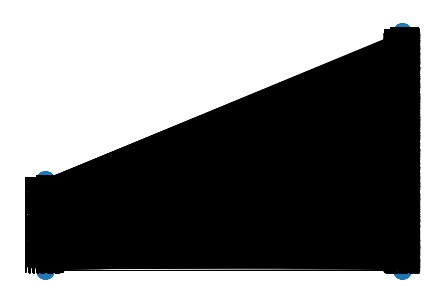

In [7]:
l, r = nx.bipartite.sets(B)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(B, pos=pos, with_labels=True)
plt.show()

In [8]:
movies = []
actors = []
# Just to see the nodes/vertices how they split in two bipartite sets
# Summation will be equal to total number of nodes again
for i in B.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [9]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(B))

# specify the metapath schemas as a list of lists of node types.
# As it is bipartite graph, walking among the same set is prohibited

metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(B.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

# This length would be equal to number of nodes(as given n=1) because from every node, random walk is taken as per the metapaths provided
# output would be 4703x100, as 100 is the maximum length of the walk can do randomly
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [10]:
from gensim.models import Word2Vec
# word2vec uses CBOW method by default 
# For generating a single vector after finding 128(given size=128) individual vectors for each word in the Corpus
model = Word2Vec(walks, size=128, window=5)

In [11]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [12]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ B.nodes[node_id]['label'] for node_id in node_ids]

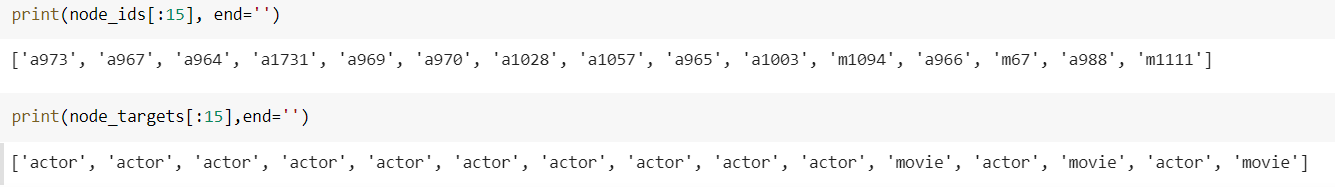

In [13]:
print(node_ids[:15],end='\n')
print(node_targets[:15],end='')

['a973', 'a967', 'a964', 'a1731', 'a969', 'a970', 'a1028', 'a965', 'a1057', 'a1003', 'm1094', 'm1111', 'a959', 'a966', 'a988']
['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'actor', 'actor']

In [15]:
# Reference: https://stackoverflow.com/questions/6294179/how-to-find-all-occurrences-of-an-element-in-a-list

def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    totalvecs = node_embeddings
    act_ids = [i for i, x in enumerate(list(node_targets)) if x == "actor"]
    mov_ids = [i for i, x in enumerate(list(node_targets)) if x == "movie"]
    actor_embeddings = totalvecs[act_ids]
    movie_embeddings = totalvecs[mov_ids]
    actor_nodes = np.array(node_ids)[act_ids]
    movie_nodes = np.array(node_ids)[mov_ids]
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


<font color='cyan'>Grader function - 1</font>

In [16]:
def grader_actors(data):
    assert(len(data)==3411)
    return True

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [17]:
def grader_movies(data):
    assert(len(data)==1292)
    return True

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [18]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
    largest_cc = max(nx.connected_components(graph), key=len)
    tot = graph.nodes()
    cost1= (1/number_of_clusters)*(len(largest_cc)/len(tot)) 
    return cost1

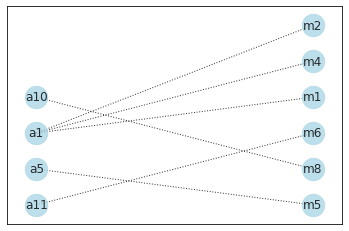

In [19]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [ ]:
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [20]:
def cost2_for_task1(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    # Numerator
    num = len(graph.edges())
    # Denominator
    den = 0
    nodes = graph.nodes()
    for node in nodes:
      if "m" in node:
        den+=1
    cost2= (1/number_of_clusters)*(num/den) 
    return cost2

def cost2_for_task2(graph,number_of_clusters):
    # Numerator
    num = len(graph.edges())
    # Denominator
    den = 0
    nodes = graph.nodes()
    for node in nodes:
      if "a" in node:
        den+=1
    cost2= (1/number_of_clusters)*(num/den) 
    return cost2

<font color='cyan'>Grader function - 4</font>

In [ ]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [21]:
from sklearn.cluster import KMeans

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

cl_sizes = [3,5,10,30,50,100,200,500]
cost = []
for cl_size in cl_sizes:
  list_of_all_clusters = []
  cost_one,cost_two = [],[]
  algo = KMeans(n_clusters=cl_size)
  # Fitting kmeans algo for various k values
  algo.fit(actor_embeddings)
  # Output will have the labels depending on the k value
  out  = algo.labels_ 
  # zip cluster numbers with an actor list and store it in a dict(dictionary_of_actor_nodes) 
  # in the form of “key” as actor and “value” as the cluster number.
  dictionary_of_actor_nodes = dict(zip(actor_nodes,list(out)))
  # creating a list for every cluster number and store actor ids of respective cluster. 
  # Finally, we will get "k" lists and we store all those lists in another list called "list_of_all_clusters".
  for cl in range(cl_size):
    temp=[]
    for j in dictionary_of_actor_nodes.keys():
      if dictionary_of_actor_nodes[j]==cl:
        temp.append(j)
    list_of_all_clusters.append(temp)
  
  for cluster in list_of_all_clusters:
    # Creating a new Graph for each cluster
    G=nx.Graph() 
    for anode in cluster: # Repeating for all actor nodes in the cluster
      # sub_graph object contains movie nodes acted by the actor id and edges from actor id to movie nodes.
      # B <--> Main Bipartite Graph
      sub_graph=nx.ego_graph(B,anode)
      # Adding nodes to the graph object(G)
      G.add_nodes_from(sub_graph.nodes())
      # Adding edges to the graph object(G)
      G.add_edges_from(sub_graph.edges())
    # Calculating cost_one and cost_two for every cluster
    cost_one.append(cost1(G,cl_size))
    cost_two.append(cost2_for_task1(G,cl_size))

  # Updating Cost value for every value of "K"
  cost.append(sum(cost_one)*sum(cost_two))
      
best_k = cl_sizes[np.argmax(np.array(cost))]
print("Best value of K:",best_k)

Best value of K: 3


In [22]:
# Fitting data with best K
algo = KMeans(n_clusters=best_k)
# Fitting kmeans algo for various k values
algo.fit(actor_embeddings)
# Output will have the labels depending on the k value
targets = list(algo.labels_)

In [23]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

<font color='blue'>Displaying similar actor clusters</font>

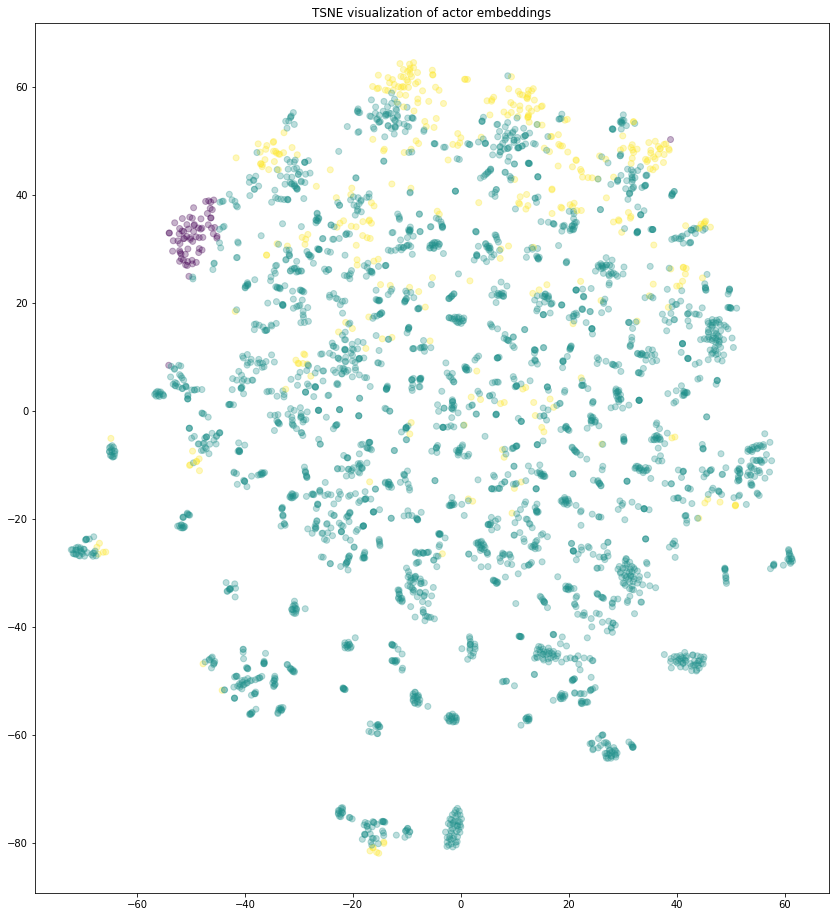

In [24]:
import numpy as np
# draw the points

## Here just we are giving colors appropriately, nothing more than that

# label_map: gives a dictionary like {0:actor,1:movie}
# So as there are only 2 types, 2 colors are enough
label_map = { l: i for i, l in enumerate(np.unique(targets))}

# As we have formed already the 4703x128 dimensional vector, each row will refer to either movie or actor
# So, we are forming a list with 0 & 1 to make color difference in the plot below 
node_colours = [label_map[target] for target in targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
# plot.scatter(1st component, 2nd component) in layman terms
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('TSNE visualization of actor embeddings')
plt.show()

<font color='blue'>Grouping similar movies</font>

In [25]:
from sklearn.cluster import KMeans

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

cl_sizes = [3,5,10,30,50,100,200,500]
cost = []
for cl_size in cl_sizes:
  list_of_all_clusters = []
  cost_one,cost_two = [],[]
  algo = KMeans(n_clusters=cl_size)
  # Fitting kmeans algo for various k values
  algo.fit(movie_embeddings)
  # Output will have the labels depending on the k value
  out  = algo.labels_ 
  # zip cluster numbers with a movie list and store it in a dict(dictionary_of_movie_nodes) 
  # in the form of “key” as movie and “value” as the cluster number.
  dictionary_of_movie_nodes = dict(zip(movie_nodes,list(out)))
  # creating a list for every cluster number and store actor ids of respective cluster. 
  # Finally, we will get "k" lists and we store all those lists in another list called "list_of_all_clusters".
  for cl in range(cl_size):
    temp=[]
    for j in dictionary_of_movie_nodes.keys():
      if dictionary_of_movie_nodes[j]==cl:
        temp.append(j)
    list_of_all_clusters.append(temp)
  
  for cluster in list_of_all_clusters:
    # Creating a new Graph for each cluster
    G=nx.Graph() 
    for mnode in cluster: # Repeating for all movie nodes in the cluster
      # sub_graph object contains movie nodes acted by the actor id and edges from actor id to movie nodes.
      # B <--> Main Bipartite Graph
      sub_graph=nx.ego_graph(B,mnode)
      # Adding nodes to the graph object(G)
      G.add_nodes_from(sub_graph.nodes())
      # Adding edges to the graph object(G)
      G.add_edges_from(sub_graph.edges())
    # Calculating cost_one and cost_two for every cluster
    cost_one.append(cost1(G,cl_size))
    cost_two.append(cost2_for_task2(G,cl_size))

  # Updating Cost value for every value of "K"
  cost.append(sum(cost_one)*sum(cost_two))
      
best_k = cl_sizes[np.argmax(np.array(cost))]
print("Best value of K:",best_k)

Best value of K: 3


In [26]:
# Fitting data with best K
algo = KMeans(n_clusters=best_k)
# Fitting kmeans algo for various k values
algo.fit(movie_embeddings)
# Output will have the labels depending on the k value
targets = list(algo.labels_)

In [27]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

<font color='blue'>Displaying similar movie clusters</font>

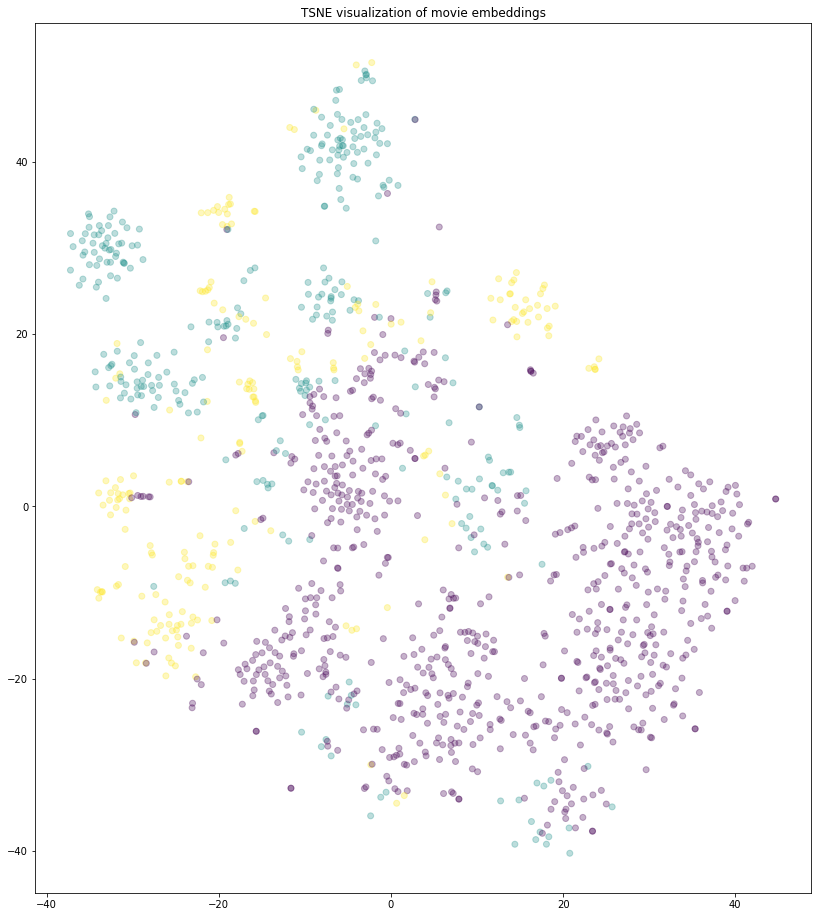

In [28]:
import numpy as np
# draw the points

## Here just we are giving colors appropriately, nothing more than that

# label_map: gives a dictionary like {0:actor,1:movie}
# So as there are only 2 types, 2 colors are enough
label_map = { l: i for i, l in enumerate(np.unique(targets))}

# As we have formed already the 4703x128 dimensional vector, each row will refer to either movie or actor
# So, we are forming a list with 0 & 1 to make color difference in the plot below 
node_colours = [label_map[target] for target in targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
# plot.scatter(1st component, 2nd component) in layman terms
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('TSNE visualization of movie embeddings')
plt.show()